# 库导入

In [2]:
import os
import glob
import utm
import pathlib
import fiona
import numpy as np
import h5py
import xarray as xr
import pandas as pd
import geopandas as gpd
from pyproj import CRS
from pyproj import Proj
from pyproj import Transformer
from osgeo import gdal,osr,ogr,gdalconst,gdalnumeric
from osgeo.gdalconst import *
import rasterio.mask
import rasterio as rio
from rasterio.crs import CRS
from rasterio.transform import from_bounds
from rasterio.warp import calculate_default_transform, reproject
import regionmask
from global_land_mask import globe
from scipy.interpolate import griddata

# TIFF文件读入与写出

## pyproj使用

In [3]:
# 1. 初始化坐标参考系统（CRS）
"""
pyproj库提供了四种初始化参考坐标的方式
括号里面的数字是地图坐标系统在epsg中的代号
每一种地图坐标系统在epsg中都有一个唯一的数值与之对应
例如，4326对应的就是WGS84地理坐标系统
对应代码坐标系统的详细信息可以在https://epsg.io/查询
"""
# 方式一 随着proj版本的升级，可能会被弃用，推荐方式二
ecef = Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla =  Proj(proj='latlong', ellps='WGS84', datum='WGS84')
# x, y, z = transform(lla, ecef, lon, lat, height, radians=False)  # radians否用弧度返回值

# 方式二
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)

# 2. 检查坐标参考系统信息
"""
直接输入刚才构造的crs对象，即可查看当前坐标系统的详细信息
在进行坐标转换之前，首先要检查坐标转换的范围和轴向信息
比如这里的wgs84地理坐标系的轴向信息是（纬度，经度）
在后面输入经纬度坐标的时候切记是先纬度，后经度的顺序，不然整个坐标系统就完全乱了，转换出来的坐标可能会出现无穷大的错误值
"""
crs

# 3. 转换坐标系
"""
在转换坐标前，首先构造一个转换对象，确定是从哪个地理坐标向哪个投影坐标进行转换
使用pyproj包的Transformer类初始化GPS转utm的类
其中第一个参数 4326 是源数据的坐标系ID，文章下文中会再进行说明
第二个参数 32750 是要转换的目标坐标系ID
"""
lat,lon = 36.64918343, 117.02233187
transform = Transformer.from_crs(crs,32750)
utm_x, utm_y = transform.transform(36.64918343, 117.02233187)
utm_x, utm_y

# 4. 使用utm包，GPS互转UTM 与pyproj的转换结果相似 可以获得utm投影带
east, north, zone_number, zone_letter = utm.from_latlon(lat,lon)
east, north, zone_number, zone_letter
lat,lon = utm.to_latlon(east, north, zone_number, zone_letter)
lat,lon

(36.64918342999959, 117.02233187)

## tif文件读写

In [4]:
DType2GDAL = {
    "uint8": gdal.GDT_Byte,
    "uint16": gdal.GDT_UInt16,
    "int16": gdal.GDT_Int16,
    "uint32": gdal.GDT_UInt32,
    "int32": gdal.GDT_Int32,
    "float32": gdal.GDT_Float32,
    "float64": gdal.GDT_Float64,
    "cint16": gdal.GDT_CInt16,
    "cint32": gdal.GDT_CInt32,
    "cfloat32": gdal.GDT_CFloat32,
    "cfloat64": gdal.GDT_CFloat64
    }

# 一、栅格数据投影转换
def read_img(filename):
    dataset = gdal.Open(filename)  # 打开文件
    if dataset is None:
        raise Exception(f"cant find/open {filename}")
    im_width = dataset.RasterXSize  # 栅格矩阵的列数
    im_height = dataset.RasterYSize  # 栅格矩阵的行数
    im_Band = dataset.RasterCount  # 栅格矩阵的波段数

    im_geotrans = dataset.GetGeoTransform()
    im_proj = dataset.GetProjection()
    im_data = dataset.ReadAsArray(0, 0, im_width, im_height)  # 将数据写成数组，对应栅格矩阵

    del dataset  # 关闭对象，文件dataset
    return im_proj, im_geotrans, im_data, im_width, im_height, im_Band

def write_img(filename, im_proj, im_geotrans, im_data):
    # 判断栅格数据的数据类型
    if im_data.dtype.name in DType2GDAL:
        datatype = DType2GDAL[im_data.dtype.name]
    else:
        datatype = gdal.GDT_Float32
    # 判读数组维数
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    # 创建文件
    if not pathlib.Path(filename).parent.exists():
        pathlib.Path(filename).parent.mkdir(parents=True, exist_ok=True)
    driver = gdal.GetDriverByName("GTiff")  # 数据类型必须有，因为要计算需要多大内存空间
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)

    dataset.SetGeoTransform(im_geotrans)  # 写入仿射变换参数
    dataset.SetProjection(im_proj)  # 写入投影
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)  # 写入数组数据
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
    del dataset
    

class RasterTransformer(object):
    def __init__(self, toEPSG):
        self.EPSG = toEPSG
        self.to_crs = osr.SpatialReference()
        self.to_crs.ImportFromEPSG(toEPSG)

    def run(self, infile, outfile):
        im_proj, im_geotrans, im_data, self.im_width, self.im_height, self.im_Band = read_img(infile)
        srs = osr.SpatialReference()
        srs.ImportFromWkt(im_proj)
        self.Transformation = osr.CoordinateTransformation(srs, self.to_crs)
        geotrans = self.setGeotrans(im_geotrans)
        # 投影转换后需要做重采样
        # gdal.ReprojectImage(ds, ts, source.ExportToWkt(), target.ExportToWkt(), gdal.GRA_Bilinear)
        write_img(outfile, self.to_crs.ExportToWkt(), geotrans, im_data)

    def setGeotrans(self, im_geotrans):
        lon, lat = self.imagexy2geo(im_geotrans, 0, 0)
        coords00 = self.Transformation.TransformPoint(lat, lon)
        lon, lat = self.imagexy2geo(im_geotrans, self.im_height, 0)
        coords01 = self.Transformation.TransformPoint(lat, lon)
        lon, lat = self.imagexy2geo(im_geotrans, 0, self.im_width)
        coords10 = self.Transformation.TransformPoint(lat, lon)

        trans = [0 for i in range(6)]
        trans[0] = coords00[0]
        trans[3] = coords00[1]
        trans[2] = (coords01[0] - trans[0]) / self.im_height
        trans[5] = (coords01[1] - trans[3]) / self.im_height
        trans[1] = (coords10[0] - trans[0]) / self.im_width
        trans[4] = (coords10[1] - trans[3]) / self.im_width
        return trans

    def imagexy2geo(self, im_geotrans, row, col):
        px = im_geotrans[0] + col * im_geotrans[1] + row * im_geotrans[2]
        py = im_geotrans[3] + col * im_geotrans[4] + row * im_geotrans[5]
        return px, py
    
# 二、单点数据投影转换
def getSRSPair(dataset):
    '''
    获得给定数据的投影参考系和地理参考系
    :param dataset: GDAL地理数据
    :return: 投影参考系和地理参考系
    '''
    prosrs = osr.SpatialReference()
    prosrs.ImportFromWkt(dataset.GetProjection())
    geosrs = prosrs.CloneGeogCS()
    return prosrs, geosrs

def geo2lonlat(dataset, x, y):
    '''
    将投影坐标转为经纬度坐标（具体的投影坐标系由给定数据确定）
    :param dataset: GDAL地理数据
    :param x: 投影坐标x
    :param y: 投影坐标y
    :return: 投影坐标(x, y)对应的经纬度坐标(lon, lat)
    '''
    prosrs, geosrs = getSRSPair(dataset)
    ct = osr.CoordinateTransformation(prosrs, geosrs)
    coords = ct.TransformPoint(x, y)
    return coords[:2]

def lonlat2geo(dataset, lon, lat):
    '''
    将经纬度坐标转为投影坐标（具体的投影坐标系由给定数据确定）
    :param dataset: GDAL地理数据
    :param lon: 地理坐标lon经度
    :param lat: 地理坐标lat纬度
    :return: 经纬度坐标(lon, lat)对应的投影坐标
    '''
    prosrs, geosrs = getSRSPair(dataset)
    ct = osr.CoordinateTransformation(geosrs, prosrs)
    coords = ct.TransformPoint(lon, lat)
    return coords[:2]

def imagexy2geo(dataset, row, col):
    '''
    根据GDAL的六参数模型将影像图上坐标（行列号）转为投影坐标或地理坐标（根据具体数据的坐标系统转换）
    :param dataset: GDAL地理数据
    :param row: 像素的行号
    :param col: 像素的列号
    :return: 行列号(row, col)对应的投影坐标或地理坐标(x, y)
    '''
    trans = dataset.GetGeoTransform()
    px = trans[0] + col * trans[1] + row * trans[2]
    py = trans[3] + col * trans[4] + row * trans[5]
    return px, py

def geo2imagexy(dataset, x, y):
    '''
    根据GDAL的六 参数模型将给定的投影或地理坐标转为影像图上坐标（行列号）
    :param dataset: GDAL地理数据
    :param x: 投影或地理坐标x
    :param y: 投影或地理坐标y
    :return: 影坐标或地理坐标(x, y)对应的影像图上行列号(row, col)
    '''
    trans = dataset.GetGeoTransform()
    a = np.array([[trans[1], trans[2]], [trans[4], trans[5]]])
    b = np.array([x - trans[0], y - trans[3]])
    return np.linalg.solve(a, b)  # 使用numpy的linalg.solve进行二元一次方程的求解

if __name__ == '__main__':
    fn = './H_201610.tif'
    change = RasterTransformer(32650)
    change.run("./H_201610.tif",'./fdem_lonlat.tif')
    gdal.AllRegister()
    dataset = gdal.Open(fn)
    print('数据投影：')
    print(dataset.GetProjection())
    print('数据的大小（行，列）：')
    print(f'({dataset.RasterYSize} {dataset.RasterXSize})')

    x = 464201
    y = 5818760
    lon = 122.47242
    lat = 52.51778
    row = 2399
    col = 3751

    print('投影坐标 -> 经纬度：')
    coords = geo2lonlat(dataset, x, y)
    print(f'({x}, {y})->({coords[0]}, {coords[1]})')
    print('经纬度 -> 投影坐标：')
    coords = lonlat2geo(dataset, lon, lat)
    print(f'({lon}, {lat})->({coords[0]}, {coords[1]})')

    print('图上坐标 -> 投影坐标：')
    coords = imagexy2geo(dataset, row, col)
    print(f'({row}, {col})->({coords[0]}, {coords[1]})')
    print('投影坐标 -> 图上坐标：')
    coords = geo2imagexy(dataset, x, y)
    print(f'({x}, {y})->({coords[0]}, {coords[1]})')

数据投影：
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
数据的大小（行，列）：
(480 840)
投影坐标 -> 经纬度：
(464201, 5818760)->(464201.0, 5818760.0)
经纬度 -> 投影坐标：
(122.47242, 52.51778)->(122.47242, 52.51778)
图上坐标 -> 投影坐标：
(2399, 3751)->(295.986892672027, -44.770920337739)
投影坐标 -> 图上坐标：
(464201, 5818760)->(11160714.967312856, -139940462.8525546)


In [5]:
'''
description: gdal读tif
param {*} tiffile
param {*} xband
param {*} xstart
param {*} ystart
param {*} ncol
param {*} nrow
return {*}
author: Luoyanping
'''
def Readtif(tiffile,xband=1,xstart=0,ystart=0,ncol=None,nrow=None):
    try:
        tiffile.endswith('.tif') or tiffile.endswith('.TIF')
        H8 = gdal.Open(tiffile)
        im_width = H8.RasterXSize
        im_height = H8.RasterYSize
        im_bands = H8.RasterCount
        cols = im_height if ncol is None else ncol
        rows = im_width if nrow is None else nrow
        # 仿射矩阵，左上角像素的大地坐标和像素分辨率。
        # 共有六个参数，分表代表左上角x坐标；东西方向上图像的分辨率；如果北边朝上，地图的旋转角度，0表示图像的行与x轴平行；左上角y坐标；
        # 如果北边朝上，地图的旋转角度，0表示图像的列与y轴平行；南北方向上地图的分辨率。
        im_geotrans = H8.GetGeoTransform()
        # 地图投影信息
        im_proj = H8.GetProjection()
        # （1）读取一个波段，其参数为波段的索引号，波段索引号从1开始(我打开的这幅图像只有一个波段)
        band = H8.GetRasterBand(xband)
        # （2）用ReadAsArray(<xoff>, <yoff>, <xsize>, <ysize>)，读出从(xoff,yoff)开始，大小为(xsize,ysize)的矩阵。以下为读取整幅图像
        im_datas = band.ReadAsArray(xstart, ystart, rows, cols)
        # （3）获取某一或某几个像素的值(查看10~14 行和 20~25 列的数据)
        data = im_datas[10:15, 20:26]
        del H8
        return im_geotrans,im_proj,im_datas
    except TypeError:
        raise "Unsupported file format"

'''
description: gdal写tif, 需要自定义投影坐标系和地理范围
param {*} path
param {*} im_data
param {*} im_width
param {*} im_height
param {*} im_bands
param {*} im_geotrans
param {*} im_proj
return {*}
author: Luoyanping
'''
def Writetif(path, im_data, im_width, im_height, im_bands, im_geotrans, im_proj=None):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32

    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    
    # 创建文件
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, im_width, im_height, im_bands, datatype)
    if (dataset != None):
        dataset.SetGeoTransform(im_geotrans)  # 写入仿射变换参数
        if im_proj is None:
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(4326)
            im_proj = srs.ExportToWkt()
        dataset.SetProjection(im_proj)  # 写入投影
    for i in range(im_bands):
        dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
    del dataset
    lon_s,lon_res,t,lat_s,t,lat_res = im_geotrans
    lon = lon_s + lon_res*np.arange(im_width )
    lat = lat_s + lat_res*np.arange(im_height)

# im_geotrans = (lon[0],1./12,0.0,lat[-1],0.0,-1./12)
# lat = ds_mean.nav_lat[:,0].values
# lon = ds_mean.nav_lon[0,:].values
# Writetif(ds_mean.values, 42, 59, 1 , im_geotrans, im_proj, 'test.tiff')

In [6]:
# 静态投影
raster = rio.open("./asi-AMSR2-s6250-20230701-v5.4.tif")
raster.crs # 坐标系
raster.transform # 仿射变换
raster.width  # 维度
raster.height # 维度
raster.count # 波段
raster.nodatavals # 缺失值
# raster.dirver # 数据格式
# 上面的所有信息，也可以通过raster.meta一次展示
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': nan,
 'width': 1264,
 'height': 1328,
 'count': 1,
 'crs': CRS.from_epsg(3976),
 'transform': Affine(6250.0, 0.0, -3950000.0,
        0.0, -6250.0, 4350000.0)}

# NC格式文件生成（Arcgis不可用）

In [7]:
def Writexrd_Geo(
    var:np.ndarray,
    lat:np.ndarray,
    lon:np.ndarray,
    description:str, 
    unit:str,
    start:str="2014-09-06",
    freq:str='D',
    ):
    if len(var.shape) == 3:
        x, y, z = var.shape
    elif len(var.shape) == 2:
        var = np.array([var])
        x, y, z = var.shape
    else:
        return None
    
    time = pd.date_range(start=start, periods=z,freq=freq)
    reference_time = pd.Timestamp(start)
    if len(lon.shape)==2:
        coords = dict(
            lon=(["x", "y"], lon),
            lat=(["x", "y"], lat),
            time=time,
            reference_time=reference_time,
        )
    elif len(lon.shape)==1:
        coords = dict(
            lon=(["y"], lon),
            lat=(["x"], lat),
            time=time,
            reference_time=reference_time,
        )
    else:
        return None
    da = xr.DataArray(
        data=temperature,
        dims=["x", "y", "time"],
        coords=coords,
        attrs=dict(
            FillValue=np.nan,
            Intercept=0,
            Slope=1,
            description=description,#'Normalized Backsactter',
            units=unit,             #'dB',
        ),
    )
    return da

ds = {}

np.random.seed(0)
temperature = 15 + 8 * np.random.randn(2, 2, 3)
lon = np.asarray([[-99.83, -99.32], [-99.79, -99.23]])
lat = np.asarray([[42.25, 42.21], [42.63, 42.59]])

da = Writexrd_Geo(temperature,lat,lon,'Ambient temperature.','degC',"2017-09-06",'M')

if da is not None:
    ds['temp'] = da
    dw = xr.Dataset(
            data_vars=ds,
            attrs=dict(
                description="Process by OUC Luoyp",
                ),
            )
    dw.to_netcdf('test.nc')

# NC转TIFF

In [8]:
# 读取nc文件
fn = "./202001.nc"
ds = xr.open_dataset(fn)
lon,lat = ds.lon.values,ds.lat.values
# NC数据的坐标、空间参考、nodata信息
ds

<xarray.Dataset>
Dimensions:           (lat: 1000, lon: 7200)
Coordinates:
  * lat               (lat) float32 -89.97 -89.93 -89.88 ... -40.08 -40.03
  * lon               (lon) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    sea_ice_fraction  (lat, lon) float32 ...

In [9]:
# 等经纬度转极地
def Transform_Tiff(src_img,dst_img):
    # src_img = 'tset.tif' # 输入图像
    # dst_img = 'output.tif' # 输出图像
    #dst_crs = crs.CRS.from_proj4('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs') # 输出图像坐标系
    dst_crs = CRS.from_epsg(3976)
    
    src_ds = rio.open(src_img)
    # 更新数据集的元数据信息
    profile = src_ds.meta.copy()
    profile.update({
        'crs': raster.crs,
        'transform': raster.transform,
        'width': raster.width,
        'height': raster.height
        })
    # 重投影并写入数据
    with rio.open(dst_img, 'w', **profile) as dst_ds:
        for i in range(1, src_ds.count + 1): # 遍历每个图层，通常只需要第一层即可
            src_array = src_ds.read(i)
            dst_array = np.empty((raster.height, raster.width), dtype=profile['dtype']) # 初始化输出图像数据
            # 重投影
            reproject(
                # 源文件参数
                source=src_array,
                src_crs=src_ds.crs,
                src_transform=src_ds.transform,
                # 目标文件参数
                destination=dst_array,
                dst_transform=raster.transform,
                dst_crs=raster.crs,
                # 其它配置
                # resampling=Resampling.average,
                num_threads=2)
            # 写入图像
            dst_ds.write(dst_array, i)

'''
description: 等经纬度数据的nc转tif
param {np} array
param {str} outfile
param {*} infile
param {*} ds
param {*} lat
param {*} lon
return {*}
author: Luoyanping
'''
def WriteNC2Tiff(array:np,outfile: str,infile: str=None,ds:xr=None,lat:np=None,lon:np=None,extent = None) -> None:
    # NC数据的坐标、空间参考、nodata信息
    try:
        if infile is not None:
            ds = xr.open_dataset(infile)
            lat_dim = [dim for dim in list(ds.dims) if "lat" in dim][0]
            lon_dim = [dim for dim in list(ds.dims) if "lon" in dim][0]
            lon,lat = ds[lon_dim].values,ds[lat_dim].values
            west, south, east, north = lon[0], lat[-1], lon[-1], lat[0]
        elif ds is not None:
            lat_dim = [dim for dim in list(ds.dims) if "lat" in dim][0]
            lon_dim = [dim for dim in list(ds.dims) if "lon" in dim][0]
            lon,lat = ds[lon_dim].values,ds[lat_dim].values
            west, south, east, north = lon[0], lat[-1], lon[-1], lat[0]
        elif lat is not None and lon is not None:
            lon,lat = lon.copy(),lat.copy()
            west, south, east, north = lon[0], lat[-1], lon[-1], lat[0]
        elif extent is not None:
            west, south, east, north = extent
    except ValueError:
        print("Array doesn't have right Dims")
    
    ndims = len(array.shape)
    if ndims==2:
        height,width = array.shape
        count = 1
        array = np.asarray([array])
    elif ndims==3:
        count,height,width = array.shape
    meic_affine = from_bounds(west, south, east, north, width, height)

    crs = CRS.from_epsg(4326)
    nodata = np.nan
    if not os.path.isdir(os.path.dirname(outfile)):
        os.makedirs(os.path.dirname(outfile))
    with rio.open(outfile, 'w', driver='GTiff', 
                height=height, width=width, 
                count=count, dtype=array.dtype, 
                crs=crs, transform=meic_affine, 
                nodata=nodata, compress='lzw') as dst:
        # 写入数据到输出文件
        for i in range(count):
            dst.write(array[i], i+1)
            
ds = xr.open_dataset("./202001.nc")
WriteNC2Tiff(ds.sea_ice_fraction.values,"./test.tif",infile=None,ds=None,lat=None,lon=None,extent=[-179.975,-40.025,180,-90])
ds.lon.values[0],ds.lon.values[-1],ds.lat.values[0],ds.lat.values[-1]
# Transform_Tiff(tiffile,polarfile)

(-179.975, 179.975, -89.975, -40.025)

# Shpfile文件读写

In [9]:
df = pd.read_excel('sy.xlsx',sheet_name=0,index_col=0)
df_sel = df[['大地X','大地Y','类型代码']]
df_sel = df_sel.rename({'大地X':'lon','大地Y':'lat','类型代码':'type'},axis='columns')
df_sel
gdf1 = gpd.GeoDataFrame(df_sel, geometry=gpd.points_from_xy(df_sel['lon'], df_sel['lat']),crs = "EPSG:4326")
gdf1.to_file("sy.geojson",driver="GeoJSON")
gdf1.to_file("sy.shp",driver='ESRI Shapefile',mode='w')

# 格点数据插值

In [10]:
def mask_land(ds, label='land', lonname='lon'):
    if lonname == 'lon':
        lat = ds.lat.data
        lon = ds.lon.data
        if np.any(lon > 180):
            lon = lon - 180
            lons, lats = np.meshgrid(lon, lat)
            mask = globe.is_ocean(lats, lons)
            temp = []
            temp = mask[:, 0:(len(lon) // 2)].copy()
            mask[:, 0:(len(lon) // 2)] = mask[:, (len(lon) // 2):]
            mask[:, (len(lon) // 2):] = temp
        else:
            lons, lats = np.meshgrid(lon, lat)# Make a grid
            mask = globe.is_ocean(lats, lons)# Get whether the points are on ocean.
        ds.coords['mask'] = (('lat', 'lon'), mask)
    elif lonname == 'longitude':
        lat = ds.latitude.data
        lon = ds.longitude.data
        if np.any(lon > 180):
            lon = lon - 180
            lons, lats = np.meshgrid(lon, lat)
            mask = globe.is_ocean(lats, lons)
            temp = []
            temp = mask[:, 0:(len(lon) // 2)].copy()
            mask[:, 0:(len(lon) // 2)] = mask[:, (len(lon) // 2):]
            mask[:, (len(lon) // 2):] = temp
        else:
            lons, lats = np.meshgrid(lon, lat)
            mask = globe.is_ocean(lats, lons)
        lons, lats = np.meshgrid(lon, lat)
        mask = globe.is_ocean(lats, lons)
        ds.coords['mask'] = (('latitude', 'longitude'), mask)
    if label == 'land':
        ds = ds.where(ds.mask == True)
    elif label == 'ocean':
        ds = ds.where(ds.mask == False)
    return ds


ssp_list = glob.glob("./ssp/*.tif")
ds = rio.open(ssp_list[0],"r")
lon = np.arange(-180,180,1)
lat = np.arange(90,50,-1)
var = ds.read(1)
mask= ~np.isnan(var)
mlon,mlat = np.meshgrid(lon,lat)
olon,olat,ovar = mlon[mask],mlat[mask],var[mask]
var_new = griddata((olon,olat),ovar,(mlon,mlat),method="linear")
ds_new = xr.DataArray(
    data= var_new,
    dims=["lat","lon"],
    coords=dict(
        lon=lon,
        lat=lat,
    )
)


In [11]:
hmask = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50.mask(ds_new)

: 

: 

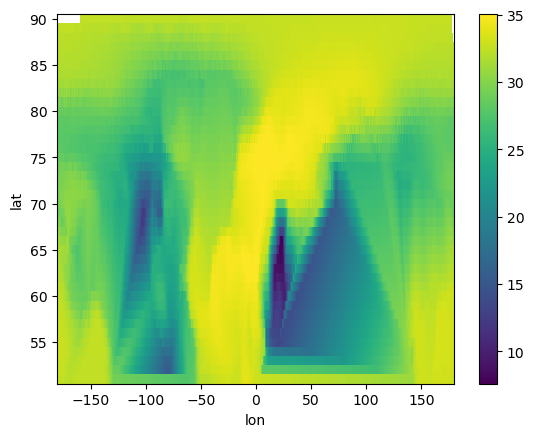

In [3]:
ds_new.plot()

: 

: 

In [6]:
lon

array([90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74,
       73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57,
       56, 55, 54, 53, 52, 51])

In [43]:
import matplotlib.pyplot as plt

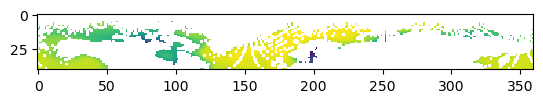

In [44]:
plt.imshow(var)

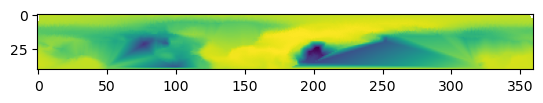

In [45]:
plt.imshow(var_new)